<a href="https://colab.research.google.com/github/glf58/Projet_Covid/blob/GLF/transfert_learningmobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import shutil
import datetime 
import tensorflow

from google.colab import drive
from zipfile import ZipFile

from sklearn.metrics import classification_report

from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomHeight, RandomWidth, RandomTranslation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

## on importe le drive local duquel on copie les data dans l'environnement colab '/content' qui disparaitra a la fin de la session

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
path_out = '/content/C19'                                                             #chemin dans l'env. colab ou on va copier les data
histo_equalize = False                                                                # sert a definir le type de donnees a utliser:  True: on recupere les images dont les histogrammes ont ete prealablement harmonises
                                                                                      #                                               False: on recupere les images originales

if histo_equalize:
  archive = '/content/drive/MyDrive/kaggle/covid19-histo_equal-dataset_for_ffd.zip'   # chemin de l'archive qui contient les donnees melangees au bon format pour ffd avec histogramme egalises
else:
  archive='/content/drive/MyDrive/kaggle/covid19--dataset_for_ffd.zip'                 # chemin de l'archive qui contient les donnees originales melangees au bon format pour ffd 
#on supprime le precedent s'il existe et on cree le repertoire pour accueillir les donnees
shutil.rmtree(path_out, ignore_errors=True)
os.mkdir(path_out)
with ZipFile(archive, 'r') as zip_ref:
  zip_ref.extractall(path_out)

## Static data utiles pour le programme

In [5]:
data_types=['Test', 'Validation', 'Train']
cats = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
initial_size = (299,299)  #taille initiale des images
target_size = (224,224)   #redimensionnement des images a 224*244 qui est ce que demande MobileNet
training_bs = 32          #batch size pour entrainement/validation
image_augmentation = False #couches d'augmentation d'image dans le modele
rotation_factor = 0.1
zoom_factor = 0.1
contrast_factor = 0.1
width_factor = 0.1
height_factor = 0.1
flip = 'horizontal_and_vertical'

# parametres du premier modele simple
dropout_rate=0.2         #taux de drop_out apres chaque couche dense
n_dense=2                #nb de couche dense apres la convolution
n_units=256              #nb de neurones pour chaque couche dense

#chemin ou on sauve les resultats
if histo_equalize:
  eq = 'HE'
else:
  eq = ''
if image_augmentation:
  ia = 'IA'
else:
  ia = ''
name = '/content/drive/MyDrive/Colab Notebooks/covid/modeles/MobileNet'+str(n_dense)+str(n_units)+str(dropout_rate)+eq+ia
name_ft = '/content/drive/MyDrive/Colab Notebooks/covid/modeles/MobileNetFineTune'+str(n_dense)+str(n_units)+str(dropout_rate)+eq+ia

#chemin ou on sauve les modeles
path_saved_models = '/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet'
path_saved_models_ft = '/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune'

## Verification des repertoires et des images

In [6]:
n_data_by_type = []
for data_type in data_types:
  n = 0
  print(data_type)
  for cat in cats:    
    print('la categorie {} possede {} images'.format(cat,len(os.listdir(os.path.join(path_out, data_type, cat)))))
    n += len(os.listdir(os.path.join(path_out, data_type, cat)))
  print('le nb total d\'images dans {} est {}'.format(data_type, n))
# on calcule le nb d'images par classes sur l'ensemble d'entrainement et on pondere chaque classe par 1/nb d'elements dans la classe pour equilibrer le dataset
n_images_train = 0
class_weights = {}
for i, cat in enumerate(cats):
  n_train_cat = len(os.listdir(os.path.join(path_out, 'Train', cat)))
  n_images_train += n_train_cat
  class_weights[i] = 1 / n_train_cat
for i in range(len(cats)):
  class_weights[i] = n_train_cat * class_weights[i]
print("class_weights utilisera les poids suivants:", class_weights)

Test
la categorie COVID possede 542 images
la categorie Lung_Opacity possede 901 images
la categorie Normal possede 1528 images
la categorie Viral Pneumonia possede 201 images
le nb total d'images dans Test est 3172
Validation
la categorie COVID possede 542 images
la categorie Lung_Opacity possede 901 images
la categorie Normal possede 1528 images
la categorie Viral Pneumonia possede 201 images
le nb total d'images dans Validation est 3172
Train
la categorie COVID possede 2531 images
la categorie Lung_Opacity possede 4209 images
la categorie Normal possede 7135 images
la categorie Viral Pneumonia possede 942 images
le nb total d'images dans Train est 14817
class_weights utilisera les poids suivants: {0: 0.3721849071513236, 1: 0.22380612972202424, 2: 0.13202522775052558, 3: 1.0}


## creation des data_generator

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)                                  
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(directory=os.path.join(path_out,'Train'),
                                                    #color_mode='grayscale',
                                                    color_mode='rgb',
                                                    class_mode='sparse', 
                                                    target_size=target_size,
                                                    batch_size=training_bs,
                                                    )

validation_generator = val_datagen.flow_from_directory(directory=os.path.join(path_out,'Validation'),
                                                         #color_mode='grayscale',
                                                       color_mode='rgb',
                                                         class_mode='sparse', 
                                                         target_size=target_size,
                                                         batch_size=training_bs,
                                                         )

test_generator = test_datagen.flow_from_directory(directory=os.path.join(path_out,'Test'),
                                                  #color_mode='grayscale',
                                                  color_mode='rgb',
                                                  class_mode='sparse', 
                                                  target_size=target_size,
                                                  shuffle = False, 
                                                  batch_size=1)


Found 14817 images belonging to 4 classes.
Found 3172 images belonging to 4 classes.
Found 3172 images belonging to 4 classes.


## on peut verifier la repartition des classes dans chacun des groupes

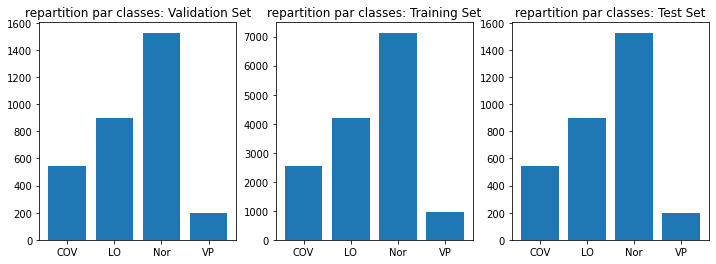

In [ ]:
classes_val, n_classes_val = np.unique(validation_generator.labels, return_counts=True)
classes_train, n_classes_train = np.unique(train_generator.labels, return_counts=True)
classes_test, n_classes_test = np.unique(test_generator.labels, return_counts=True)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('repartition par classes: Validation Set')
plt.bar(classes_val, n_classes_val)
plt.xticks(classes_val, ['COV', 'LO', 'Nor', 'VP'])
plt.subplot(132)
plt.title('repartition par classes: Training Set')
plt.bar(classes_train, n_classes_train)
plt.xticks(classes_train, ['COV', 'LO', 'Nor', 'VP'])
plt.subplot(133)
plt.title('repartition par classes: Test Set')
plt.bar(classes_test, n_classes_test)
plt.xticks(classes_test, ['COV', 'LO', 'Nor', 'VP'])

if False:
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/covid/modeles/repartition_data.png')

plt.show()

## ATTENTION: pas encore utilise, a modifier pour prendre en compte les images en RGB; creation des couches d'augmentation d'images
On le fait dans le modele directement, cela est plus rapide avec le GPU

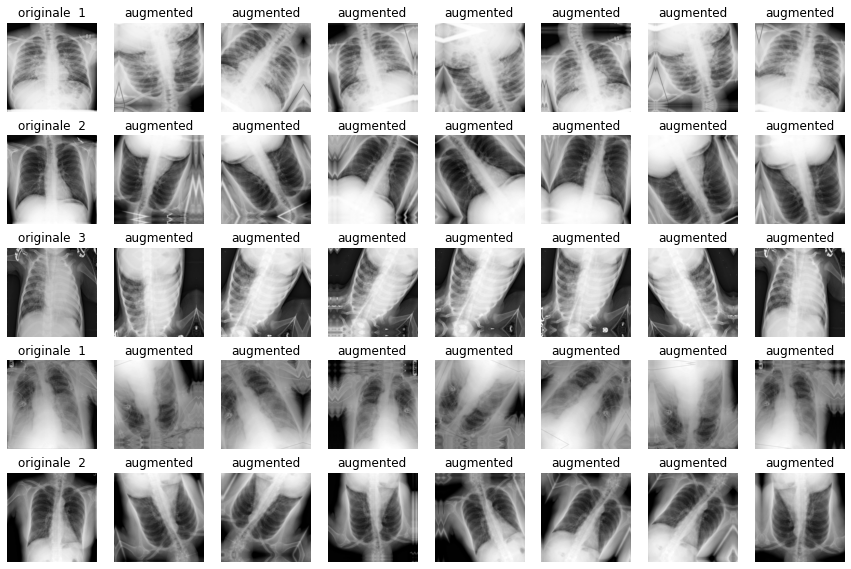

In [ ]:
#ne fonctionne pas tel quel
#images a redimensionner pour prendre en compte RGB
data_augmentation = Sequential(
    [
        RandomFlip(flip),
        RandomRotation(rotation_factor),
        #RandomRotation(0.1),
        #RandomZoom(0.8),
        RandomZoom(zoom_factor),
        #RandomContrast(contrast_factor),
        #RandomContrast(0.1),
        #RandomHeight(0.2), 
        #RandomWidth(0.2),
        RandomTranslation(height_factor,width_factor),
        #RandomTranslation(0.2,0.2),
    ]
)
#data_augmentation.build(input_shape=(target_size[0], target_size[1], 1))

nb_img = 5
nb_transformation = 7
fig, axs = plt.subplots(nb_img, nb_transformation+1, figsize=(15,10))

train_generator.reset()
for row in range(nb_img):
  images, labels = train_generator.next()
  #indice = np.random.randint(images.shape[0])
  img = images[0].reshape(target_size)
  axs[row, 0].imshow((1.0+img)/2.0)
  axs[row, 0].axis('off')
  axs[row, 0].set_title('originale  '+str(int(labels[0])))
  for col in range(1,nb_transformation+1):
    augmented_images = data_augmentation(images)
    img = augmented_images[0].numpy().astype("uint8")
    axs[row, col].imshow(img.reshape(img.shape[0],img.shape[1]), cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title('augmented')

train_generator.reset()

# !!!! ne pas utiliser randomcontrast qui va generer des taches blanches et noires


#Creation du modele

In [8]:
base_model = MobileNet(weights='imagenet', include_top=False)
for layer in base_model.layers:
  layer.trainable = False
  

17235968/17225924 [==============================] - 0s 0us/step


In [9]:
def build_model(dropout_rate, n_dense, n_units, loss, summary):
    #if image_augmentation:
    #  mod.add(data_augmentation)
    mod = Sequential()
    mod.add(base_model)
    mod.add(GlobalAveragePooling2D())
    for i in range(n_dense):
      mod.add(Dense(units=n_units, activation='relu'))
      mod.add(Dropout(rate=dropout_rate))
    mod.add(Dense(units = 4, activation='softmax'))
      
    mod.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    if summary:
      mod.summary()

    return(mod)

model = build_model(dropout_rate=dropout_rate, n_dense=n_dense, n_units=n_units, loss='sparse_categorical_crossentropy', summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

## entrainement du modele

In [10]:
es = EarlyStopping(monitor="val_loss",
                   min_delta=0.001,
                   patience=4,
                   mode="min",
                   restore_best_weights=True, 
                   verbose=1)

red_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.5, 
                           patience=2, 
                           min_delta = 0.01, 
                           #cooldown=3, 
                           verbose=1)

checkpoint = ModelCheckpoint(filepath=path_saved_models, save_best_only=True, verbose=1)

training_history_model = model.fit_generator(train_generator, 
                                             epochs=20,
                                             steps_per_epoch = train_generator.samples//train_generator.batch_size,
                                             validation_data = validation_generator,
                                             validation_steps = validation_generator.samples//validation_generator.batch_size,
                                             class_weight=class_weights,
                                             callbacks=[es, red_lr, checkpoint]
                                             )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
463/463 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.7713
Epoch 1: val_loss improved from inf to 0.33492, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet/assets


463/463 [==============================] - 108s 209ms/step - loss: 0.1271 - accuracy: 0.7713 - val_loss: 0.3349 - val_accuracy: 0.8759 - lr: 0.0010
Epoch 2/20
463/463 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.8468
Epoch 2: val_loss did not improve from 0.33492
463/463 [==============================] - 69s 149ms/step - loss: 0.0833 - accuracy: 0.8468 - val_loss: 0.3718 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 3/20
463/463 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.8705
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_loss did not improve from 0.33492
463/463 [==============================] - 69s 149ms/step - loss: 0.0704 - accuracy: 0.8705 - val_loss: 0.3428 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 4/20
463/463 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.8974
Epoch 4: val_loss improved from 0.33492 to 0.26980, saving model to /content/drive/MyDrive/Colab No

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet/assets


463/463 [==============================] - 78s 168ms/step - loss: 0.0557 - accuracy: 0.8974 - val_loss: 0.2698 - val_accuracy: 0.9018 - lr: 5.0000e-04
Epoch 5/20
463/463 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.8921
Epoch 5: val_loss did not improve from 0.26980
463/463 [==============================] - 64s 138ms/step - loss: 0.0563 - accuracy: 0.8921 - val_loss: 0.2933 - val_accuracy: 0.8946 - lr: 5.0000e-04
Epoch 6/20
463/463 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9056
Epoch 6: val_loss improved from 0.26980 to 0.25956, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet/assets


463/463 [==============================] - 87s 188ms/step - loss: 0.0498 - accuracy: 0.9056 - val_loss: 0.2596 - val_accuracy: 0.9085 - lr: 5.0000e-04
Epoch 7/20
463/463 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9098
Epoch 7: val_loss did not improve from 0.25956
463/463 [==============================] - 64s 137ms/step - loss: 0.0456 - accuracy: 0.9098 - val_loss: 0.2834 - val_accuracy: 0.8924 - lr: 5.0000e-04
Epoch 8/20
463/463 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9146
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: val_loss did not improve from 0.25956
463/463 [==============================] - 63s 137ms/step - loss: 0.0434 - accuracy: 0.9146 - val_loss: 0.2973 - val_accuracy: 0.8854 - lr: 5.0000e-04
Epoch 9/20
463/463 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9265
Epoch 9: val_loss improved from 0.25956 to 0.24854, saving model to /content/drive/MyDri

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet/assets


463/463 [==============================] - 76s 164ms/step - loss: 0.0360 - accuracy: 0.9265 - val_loss: 0.2485 - val_accuracy: 0.9104 - lr: 2.5000e-04
Epoch 10/20
463/463 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9295
Epoch 10: val_loss did not improve from 0.24854
463/463 [==============================] - 63s 137ms/step - loss: 0.0343 - accuracy: 0.9295 - val_loss: 0.2561 - val_accuracy: 0.9066 - lr: 2.5000e-04
Epoch 11/20
463/463 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9326
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 11: val_loss did not improve from 0.24854
463/463 [==============================] - 63s 136ms/step - loss: 0.0330 - accuracy: 0.9326 - val_loss: 0.2697 - val_accuracy: 0.8946 - lr: 2.5000e-04
Epoch 12/20
463/463 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9395
Epoch 12: val_loss did not improve from 0.24854
463/463 [=========================

In [11]:
   def show_training_model(hist, save=False, mod='mod'):
    fig = plt.figure(figsize=(10,5))
    epochs = len(hist.history['accuracy'])
    ax1 = fig.add_subplot(121)
    ax1.plot(np.arange(1,epochs+1,1), hist.history['accuracy'], 'blue', label='training')
    ax1.plot(np.arange(1,epochs+1,1), hist.history['val_accuracy'], 'r', label='validation')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    ax1.legend()
    ax2 = fig.add_subplot(122)
    ax2.plot(np.arange(1,epochs+1,1), hist.history['loss'], 'blue', label='training')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax3 = ax2.twinx()
    ax3.plot(np.arange(1,epochs+1,1), hist.history['val_loss'], 'r', label='validation')
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('Loss')
    ax3.legend(loc='upper left')
    if save:
        plt.savefig(mod+'.png')

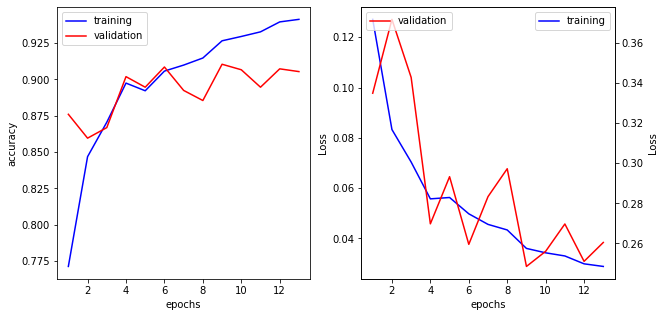

In [12]:

show_training_model(training_history_model, save=True, mod=name)

#Avant d'affiner les parametres, on regarde la performance sur test et on enregistre les resultats

In [13]:
def perf_model_on_test(mod, test_generator):
#  print("performance du modele sur ensemble de test:", mod.evaluate(test_generator)[1])
  test_generator.reset()
  y_pred = mod.predict(x=test_generator, 
                         steps=test_generator.samples//test_generator.batch_size, 
                         verbose=1)
  y_pred_class = np.argmax(y_pred, axis=1)
  y_test_class = test_generator.labels
  report = classification_report(y_test_class, y_pred_class)
  cm = pd.crosstab(y_test_class, y_pred_class, rownames=['realite'], colnames=['prediction'])

  return report, cm

In [14]:
cr, cm = perf_model_on_test(model, test_generator)
print(cr)
print(cm)

3172/3172 [==============================] - 25s 8ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       542
           1       0.92      0.87      0.89       901
           2       0.92      0.94      0.93      1528
           3       0.96      0.98      0.97       201

    accuracy                           0.92      3172
   macro avg       0.93      0.93      0.93      3172
weighted avg       0.92      0.92      0.92      3172

prediction    0    1     2    3
realite                        
0           508   11    22    1
1            18  780   103    0
2            24   60  1436    8
3             0    1     4  196


In [17]:
def save_config_and_model_results(dropout_rate, n_dense, n_units, train_hist, class_report, confusion_matrix, name):
  res = {}
  res['date'] = str(datetime.datetime.today()).split()[0]
  res['target_size'] = target_size   
  res['Nmax'] = 11200
  res['histo_equalize'] = histo_equalize
  res['image_augmentation'] = image_augmentation
  res['rotation_factor'] = rotation_factor
  res['zoom_factor'] = zoom_factor
  res['contrast_factor'] = contrast_factor
  res['flip'] = flip
  res['val_split'] = 15
  res['test_split'] = 15
  res['hist'] = train_hist.history
  res['cr'] = class_report
  res['confusion_matrix'] = confusion_matrix
  res['drop_out'] = dropout_rate
  res['n_dense'] = n_dense
  res['n_units'] = n_units
  np.save(name, res)

In [18]:
save_config_and_model_results(dropout_rate, n_dense, n_units,training_history_model, cr, cm, name+'.npy')

# on va tester que l'enregistrement du modele s'est bien deroule

In [ ]:
#on va tester que l'enregistrement du modele s'est bien deroule
cr, cm = perf_model_on_test(model, test_generator)
print(cr)
print(cm)

3172/3172 [==============================] - 20s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       542
           1       0.91      0.86      0.88       901
           2       0.90      0.95      0.93      1528
           3       0.92      0.99      0.95       201

    accuracy                           0.92      3172
   macro avg       0.92      0.92      0.92      3172
weighted avg       0.92      0.92      0.92      3172

prediction    0    1     2    3
realite                        
0           476   30    34    2
1             6  776   119    0
2             8   49  1455   16
3             0    0     3  198


In [ ]:
#reproduisons les memes resultats avec le modele issu du point de sauvegarde
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet')

In [ ]:
cr2, cm2 = perf_model_on_test(new_model, test_generator)
print(cr2)
print(cm2)

3172/3172 [==============================] - 22s 7ms/step
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       542
           1       0.91      0.86      0.88       901
           2       0.90      0.95      0.93      1528
           3       0.92      0.99      0.95       201

    accuracy                           0.92      3172
   macro avg       0.92      0.92      0.92      3172
weighted avg       0.92      0.92      0.92      3172

prediction    0    1     2    3
realite                        
0           476   30    34    2
1             6  776   119    0
2             8   49  1455   16
3             0    0     3  198


# On va affiner les parametres du modele

In [19]:
# on va affiner les parametres
for layer in base_model.layers:
  layer.trainable = True

#on baisse lr a 0.00001
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])

checkpoint2 = ModelCheckpoint(filepath=path_saved_models_ft, save_best_only=True, verbose=1)

training_history_model_finetune = model.fit_generator(train_generator, 
                                             epochs=50,
                                             steps_per_epoch = train_generator.samples//train_generator.batch_size,
                                             validation_data = validation_generator,
                                             validation_steps = validation_generator.samples//validation_generator.batch_size,
                                             class_weight=class_weights,
                                             callbacks=[es, red_lr, checkpoint2]
                                             )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/50
463/463 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.7464
Epoch 1: val_loss improved from inf to 0.64231, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


463/463 [==============================] - 172s 361ms/step - loss: 0.2179 - accuracy: 0.7464 - val_loss: 0.6423 - val_accuracy: 0.7869 - lr: 1.0000e-05
Epoch 2/50
463/463 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.8561
Epoch 2: val_loss improved from 0.64231 to 0.37665, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


463/463 [==============================] - 166s 359ms/step - loss: 0.0873 - accuracy: 0.8561 - val_loss: 0.3767 - val_accuracy: 0.8687 - lr: 1.0000e-05
Epoch 3/50
463/463 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.8873
Epoch 3: val_loss improved from 0.37665 to 0.29820, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


463/463 [==============================] - 170s 367ms/step - loss: 0.0595 - accuracy: 0.8873 - val_loss: 0.2982 - val_accuracy: 0.8987 - lr: 1.0000e-05
Epoch 4/50
463/463 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9036
Epoch 4: val_loss improved from 0.29820 to 0.27401, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


463/463 [==============================] - 168s 362ms/step - loss: 0.0504 - accuracy: 0.9036 - val_loss: 0.2740 - val_accuracy: 0.9078 - lr: 1.0000e-05
Epoch 5/50
463/463 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9178
Epoch 5: val_loss improved from 0.27401 to 0.26806, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


463/463 [==============================] - 175s 378ms/step - loss: 0.0413 - accuracy: 0.9178 - val_loss: 0.2681 - val_accuracy: 0.9100 - lr: 1.0000e-05
Epoch 6/50
463/463 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9284
Epoch 6: val_loss improved from 0.26806 to 0.25009, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


463/463 [==============================] - 166s 359ms/step - loss: 0.0350 - accuracy: 0.9284 - val_loss: 0.2501 - val_accuracy: 0.9160 - lr: 1.0000e-05
Epoch 7/50
463/463 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9330
Epoch 7: val_loss improved from 0.25009 to 0.23250, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


463/463 [==============================] - 170s 367ms/step - loss: 0.0308 - accuracy: 0.9330 - val_loss: 0.2325 - val_accuracy: 0.9217 - lr: 1.0000e-05
Epoch 8/50
463/463 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9424
Epoch 8: val_loss improved from 0.23250 to 0.22677, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNetFineTune/assets


463/463 [==============================] - 169s 364ms/step - loss: 0.0273 - accuracy: 0.9424 - val_loss: 0.2268 - val_accuracy: 0.9236 - lr: 1.0000e-05
Epoch 9/50
463/463 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9471
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 9: val_loss did not improve from 0.22677
463/463 [==============================] - 151s 326ms/step - loss: 0.0247 - accuracy: 0.9471 - val_loss: 0.2294 - val_accuracy: 0.9249 - lr: 1.0000e-05
Epoch 10/50
463/463 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9539
Epoch 10: val_loss did not improve from 0.22677
463/463 [==============================] - 152s 329ms/step - loss: 0.0218 - accuracy: 0.9539 - val_loss: 0.2295 - val_accuracy: 0.9268 - lr: 5.0000e-06
Epoch 11/50
463/463 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9560
Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoc

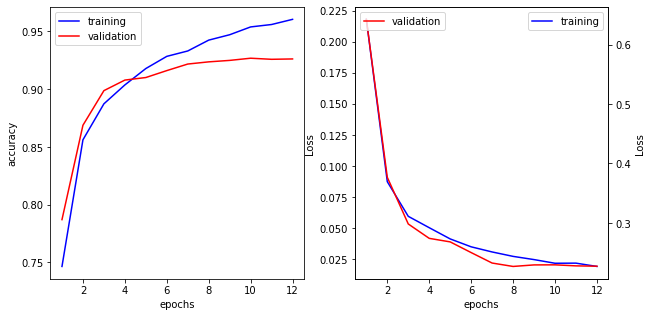

In [20]:
show_training_model(training_history_model_finetune, save=True, mod=name_ft)

## Rergardons la performance du modele sur l'ensemble de test

In [21]:
cr_finetune, cm_finetune = perf_model_on_test(model, test_generator)
print(cr_finetune)
print(cm_finetune)

3172/3172 [==============================] - 25s 8ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       542
           1       0.89      0.90      0.90       901
           2       0.94      0.93      0.93      1528
           3       0.95      0.98      0.96       201

    accuracy                           0.93      3172
   macro avg       0.93      0.94      0.94      3172
weighted avg       0.93      0.93      0.93      3172

prediction    0    1     2    3
realite                        
0           511   12    17    2
1             9  815    77    0
2            15   84  1420    9
3             1    0     4  196


In [22]:
save_config_and_model_results(dropout_rate, n_dense, n_units,training_history_model_finetune, cr_finetune, cm_finetune, name_ft+'.npy')

In [23]:
 #verification que l'enregistrement des resultats s'est bien deroule

new_dict = np.load(name_ft+'.npy', allow_pickle='TRUE').item()

cr1 = new_dict['cr']
cm1 = new_dict['confusion_matrix']
print(cr1)
print(cm1)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       542
           1       0.89      0.90      0.90       901
           2       0.94      0.93      0.93      1528
           3       0.95      0.98      0.96       201

    accuracy                           0.93      3172
   macro avg       0.93      0.94      0.94      3172
weighted avg       0.93      0.93      0.93      3172

prediction    0    1     2    3
realite                        
0           511   12    17    2
1             9  815    77    0
2            15   84  1420    9
3             1    0     4  196


In [24]:
new_dict['hist']['accuracy']

[0.7463645339012146,
 0.856070339679718,
 0.8872506022453308,
 0.9036185145378113,
 0.9178221225738525,
 0.9283733367919922,
 0.9330402612686157,
 0.9424416422843933,
 0.9471085667610168,
 0.9538721442222595,
 0.9559689164161682,
 0.9604328870773315]

#rechargeons le modele et regardons quelques images qui n'ont pas ete bien classees

In [ ]:
#rechargeons le modele
new_model = load_model(path_saved_models_ft)

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [ ]:
y_pred = new_model.predict(x=test_generator, 
                         steps=test_generator.samples//test_generator.batch_size, 
                         verbose=1)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = test_generator.labels
report = classification_report(y_test_class, y_pred_class)
cm = pd.crosstab(y_test_class, y_pred_class, rownames=['realite'], colnames=['prediction'])

3172/3172 [==============================] - 21s 7ms/step


In [ ]:
print(report)
print(cm)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       542
           1       0.86      0.90      0.88       901
           2       0.92      0.92      0.92      1528
           3       0.95      0.94      0.95       201

    accuracy                           0.91      3172
   macro avg       0.92      0.92      0.92      3172
weighted avg       0.91      0.91      0.91      3172

prediction    0    1     2    3
realite                        
0           496   22    22    2
1            11  807    83    0
2            10  107  1403    8
3             1    0    11  189


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


277 [1, 2, 20, 37, 53, 60, 70, 80, 94, 134, 144, 153, 160, 163, 196, 198, 233, 237, 254, 260, 263, 265, 275, 281, 289, 299, 325, 340, 344, 348, 349, 372, 379, 380, 406, 432, 449, 458, 462, 467, 484, 503, 507, 517, 533, 537, 570, 607, 613, 620, 630, 644, 645, 652, 662, 672, 679, 684, 699, 707, 710, 729, 757, 776, 779, 786, 818, 821, 835, 846, 847, 850, 876, 884, 888, 890, 895, 902, 911, 973, 980, 984, 990, 991, 999, 1013, 1017, 1027, 1059, 1060, 1068, 1069, 1078, 1080, 1093, 1094, 1099, 1102, 1120, 1126, 1131, 1132, 1138, 1140, 1152, 1155, 1156, 1158, 1167, 1176, 1178, 1179, 1184, 1185, 1191, 1196, 1201, 1214, 1215, 1217, 1246, 1251, 1273, 1279, 1281, 1290, 1292, 1303, 1306, 1324, 1328, 1342, 1360, 1395, 1405, 1413, 1415, 1423, 1430, 1431, 1455, 1465, 1487, 1515, 1547, 1561, 1568, 1579, 1602, 1628, 1630, 1631, 1676, 1702, 1708, 1710, 1718, 1720, 1732, 1744, 1746, 1754, 1762, 1776, 1796, 1847, 1889, 1910, 1925, 1940, 1983, 1988, 1993, 2025, 2030, 2040, 2043, 2046, 2058, 2072, 2074, 2082,

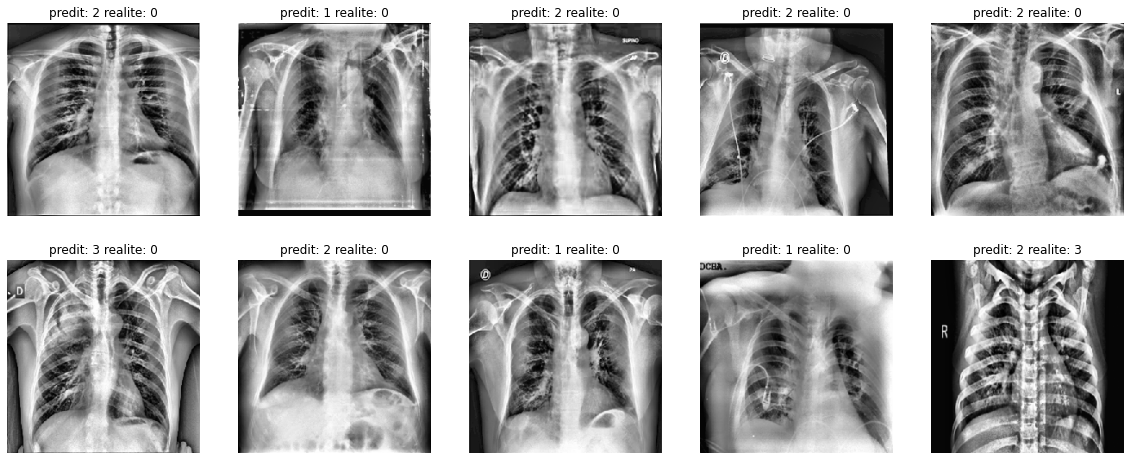

In [ ]:
#sortons les images mal classees et regardons les 10 premieres

n_affiche=10
fig = plt.figure(figsize=(20,8))
cpteur = 0
liste_error = []
test_generator.reset()
for i in range(len(y_pred_class)):
  image, label = test_generator.next()
  if y_pred_class[i] != y_test_class[i]:
    plt.subplot(2,n_affiche//2,min(cpteur+1,n_affiche))
    img = image[0]
    plt.imshow((1.0+img)/2.0) #en sortie de preprocessing, les images sont normalisees entre -1 et 1; on les ramene entre 0 et 1 pour un affichage correct
    plt.title("predit: {} realite: {}".format(y_pred_class[i], int(label[0])))
    plt.axis("off");
    #print(img.shape, img.max(), label, y_test_class[i], y_pred_class[i])
    liste_error.append(i)
    #print('le modele a prevu {} a la place de {}'.format(y_pred_class[i], y_test_class[i]))
    cpteur += 1
print(cpteur, liste_error)
